In [64]:
from core.semcor_bert_pipeline import SemCorSelector, get_sense_labels, load_data
from core.clustering import *

Before we inspect the attentions, we sanity check the results of the pipeline with dendrograms. We should be able to replicate the old results after migrating to the new `transformers` library.

In [65]:
new_version = load_data('cover', 'v', 'semcor_attention')
old_version = load_data('cover', 'v', 'semcor')

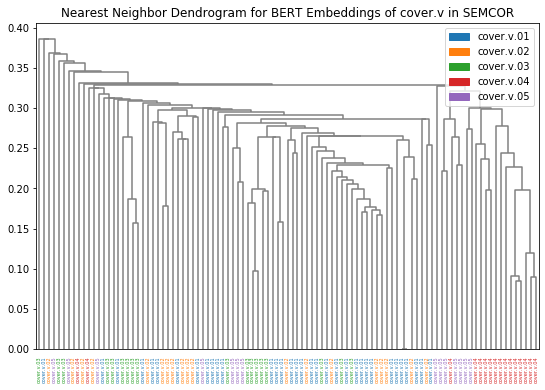

In [66]:
color_dict, label_dict = create_dendrogram_colors(np.unique(new_version['sense_labels']))
plot_dendrogram(new_version, color_dict, label_dict, savefile = False)

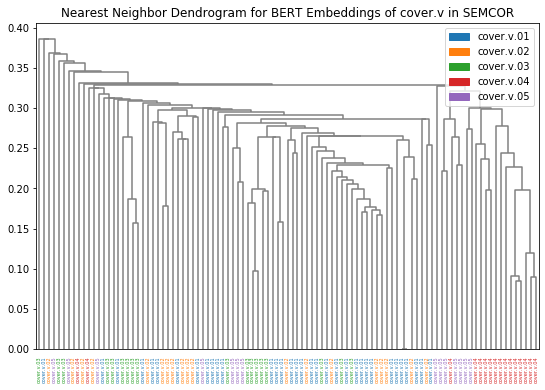

In [67]:
plot_dendrogram(old_version, color_dict, label_dict, savefile = False)

Finding words with two senses to look at attention (some of these have more than 2- come back to this)

In [62]:
model_perf = pd.read_csv('../data/model_perf.csv')
model_perf[model_perf['num_senses'] == 2].sort_values('freq', ascending = False)[:10]

,word,avg_f1,avg_acc,Lemma,pos,entropy,num_senses,freq,Part of Speech
396,seem.v,0.912612,0.916355,seem.v,v,0.532687,2,586,Verb
219,become.v,0.798214,0.798039,become.v,v,0.970951,2,510,Verb
376,mean.v,0.758743,0.764898,mean.v,v,0.666974,2,247,Verb
370,form.n,0.861471,0.860976,form.n,n,0.681291,2,216,Noun
316,child.n,0.860393,0.863995,child.n,n,0.870346,2,206,Noun
96,need.v,0.598272,0.602561,need.v,v,0.996600,2,204,Verb
186,work.n,0.685212,0.703846,work.n,n,0.989793,2,202,Noun
282,number.n,0.735549,0.738327,number.n,n,0.909736,2,200,Noun
276,add.v,0.909007,0.911606,add.v,v,0.916559,2,193,Verb
364,problem.n,0.743810,0.757219,problem.n,n,0.701355,2,179,Noun


In [78]:
attn_types = ['child.n', 'number.n', 'problem.n', 'seem.v', 'table.n']

In [79]:
table_data = load_data('table', 'n', 'semcor_attention')

In [105]:
layer_0_attn = [t['0'] for t in table_data['attns']]
np.count_nonzero([not np.isclose(sum(i), 1) for i in layer_0_attn]) 
#Verifying we get a distribution over attention weights

0

In [100]:
#Verifying that token lengths are the same
np.count_nonzero([len(layer_0_attn[i]) != len(table_data['tokenized_sentences'][i][0]) for i in range(len(layer_0_attn))])

0

In [146]:
def attn_df_for_layer(data, layer):
    layer_0_attn = [t[str(layer)] for t in data['attns']]
    sentences = [i[0] for i in data['tokenized_sentences']]
    word_attn = []
    sentence_index = 0
    for v, s in zip(layer_0_attn, sentences): #iterating over attn vectors, sentences
        sense = data['sense_labels'][sentence_index]
        for e, t in zip(v, s): #iterating over element in vector and token in sentence
            word_attn.append({"sent_idx": sentence_index, "token": t, "attn": e, 'sense': sense})
        sentence_index += 1
    attn = pd.DataFrame(word_attn)
    return attn

In [141]:
tbl_attn = pd.DataFrame(word_attn)
mean_attn = tbl_attn[tbl_attn['sense'] == 'table.n.01'].groupby('token').agg('mean')
cnt = tbl_attn[tbl_attn['sense'] == 'table.n.01'].groupby('token').agg('count')['sense']
pd.DataFrame({"count": cnt, "avg_attn": mean_attn['attn']}).sort_values("avg_attn", ascending = False)[:10]

,count,avg_attn
token,,
discussing,1,0.235661
illustrates,1,0.214427
but,1,0.138676
7,2,0.135857
summarized,1,0.132695
##rated,1,0.127366
correlation,1,0.125500
charts,1,0.121989
examination,1,0.121230


In [142]:
tbl_attn = pd.DataFrame(word_attn)
mean_attn = tbl_attn[tbl_attn['sense'] == 'table.n.02'].groupby('token').agg('mean')
cnt = tbl_attn[tbl_attn['sense'] == 'table.n.02'].groupby('token').agg('count')['sense']
pd.DataFrame({"count": cnt, "avg_attn": mean_attn['attn']}).sort_values("avg_attn", ascending = False)[:10]

,count,avg_attn
token,,
bedside,1,0.246482
tray,1,0.167025
everything,1,0.151329
hall,1,0.147522
bridge,1,0.135965
cafeteria,1,0.134440
chair,1,0.122302
##cope,1,0.116047
long,1,0.115338


In [144]:
foot_data = load_data('foot', 'n', 'semcor_attention')

In [163]:
foot_attn = attn_df_for_layer(foot_data, 0)
mean_attn = foot_attn[foot_attn['sense'] == 'foot.n.01'].groupby('token').agg('mean')
cnt = foot_attn[foot_attn['sense'] == 'foot.n.01'].groupby('token').agg('count')['sense']
pd.DataFrame({"count": cnt, "avg_attn": mean_attn['attn']}).sort_values("avg_attn", ascending = False)[:10]

,count,avg_attn
token,,
bare,2,0.269445
tanned,1,0.177495
landing,3,0.172765
kick,3,0.157680
right,2,0.150835
##agger,1,0.150481
gingerly,1,0.148435
##placed,1,0.134995
squeezing,2,0.134140


In [150]:
mean_attn = foot_attn[foot_attn['sense'] == 'foot.n.02'].groupby('token').agg('mean')
cnt = foot_attn[foot_attn['sense'] == 'foot.n.02'].groupby('token').agg('count')['sense']
pd.DataFrame({"count": cnt, "avg_attn": mean_attn['attn']}).sort_values("avg_attn", ascending = False)[:10]

,count,avg_attn
token,,
70,1,0.225863
million,1,0.218866
55,1,0.203090
twenty,1,0.199402
26,1,0.196042
fifty,4,0.191553
tall,2,0.190204
twelve,1,0.188330
nine,2,0.171710
